In [63]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import timeit

matplotlib.rcParams['figure.figsize'] = (100.0, 50.0)

import numpy as np
import scipy as sp

In [64]:
def setupdata():
    # accept the beam geometry
    geom = np.array(list(map(float, input('Enter the length, breadth and thickness (in m):').split())))
    # accept the two  moduli of elasticity
    E = np.array(list(map(float, input('Enter the two moduli of elasticity: (in Pa)').split())))
    # accept the Poisson ratio
    nu = float(input('Enter the Poisson ratio:'))
    # accept the number of divisions
    divs = np.array(list(map(int, input('Enter the number of divisions along x and y:').split())))
    dels = [geom[i]/divs[i] for i in range(2)]
    return (geom, E, nu, divs, dels)

def bcdata():
    # accept the external force
    frange = np.array(list(map(int, 
                               input('Enter the start and end node numbers on which force is applied:')
                           .split())))
    f = list(map(float,(input(
                        'Enter the x and y components of force applied on the beam in this range (in Newton):')
                        .split())))
    print('Neumann boundary conditions are assumed at the free horizontal edges of the beam.')
    print('Dirichlet boundary conditions are taken for the fixed vertical edges.')
    return (frange, f)
    
def bfdata():
    # accept the body force
    bf = list(map(float,(input('Enter the x and y components of body force (in N/m^2)').split())))
    return bf

def xandy(divs, dels):
    x = [i*dels[0] for i in range(divs[0]+1)]
    y = [(divs[1]-i)*dels[1] for i in range(divs[1]+1)]
    xy = [x, y]
    return xy

In [65]:
def lambda_mu(E, nu):
    c1 = nu/(1+nu)/(1-2*nu)
    c2 = 2*(1+nu)
    lamb = E*c1
    mu = E*1/c2
    return lamb, mu

In [66]:
def N_of_zi(zi):
    # input : 2D zi vector corresponding to an element
    # output : values of 4 basis functions for the given zi (for the element)
    N = np.array([0.25*(1-zi[0])*(1-zi[1]), 0.25*(1+zi[0])*(1-zi[1]), 
                  0.25*(1+zi[0])*(1+zi[1]), 0.25*(1-zi[0])*(1+zi[1])])
    return N

In [67]:
def N_der_zi(zi):
    # input : 2D zi vector
    # output : 2x4 array of derivatives of each basis function wrt zi1 and zi2
    Nder_zi = np.array([[-0.25*(1-zi[1]), 0.25*(1-zi[1]), 0.25*(1+zi[1]), -0.25*(1+zi[1])], 
                  [-0.25*(1-zi[0]), -0.25*(1+zi[0]), 0.25*(1+zi[0]), 0.25*(1-zi[0])]])
    return Nder_zi

In [68]:
def elementlist(nx, ny, divs):
    # lists the nodes in each element
    if (nx, ny) != (divs[0], divs[1]):
        print("Error. Exiting elementlist().")
        return 0
    elist = np.array([[ [(i+1, j), (i+1, j+1), (i,j+1), (i, j)] for j in range(nx)] for i in range(ny)])
    return elist

In [69]:
def element_nodelist(el_id, elist):
    return elist(el_id)

In [70]:
def x_of_zi(nodelist, zi, xy):
    xvec = []
    yvec = []
    for node in nodelist:
        xvec.append(xy[0][node[1]])
        yvec.append(xy[1][node[0]])
    N = N_of_zi(zi)
    x_el = [np.dot(N, xvec), np.dot(N, yvec)]
    return x_el

In [71]:
def x_der_zi(nodelist, zi, xy):
    xvec = []
    yvec = []
    for node in nodelist:
        try:
            xvec.append(xy[0][node[1]])
            yvec.append(xy[1][node[0]])
        except IndexError:
            print(node)
    xder_zi = np.array([np.dot(N_der_zi(zi)[0],xvec), np.dot(N_der_zi(zi)[1],xvec), 
               np.dot(N_der_zi(zi)[0],yvec), np.dot(N_der_zi(zi)[1],yvec) ])
    return xder_zi

In [72]:
def jacobian(nodelist, zi, xy):
    jac = x_der_zi(nodelist, zi, xy).reshape((2, 2))
    return jac

def jacobian_inverse(nodelist, zi, xy):
    jac = x_der_zi(nodelist, zi, xy).reshape((2, 2))
    jacinv = np.linalg.inv(jac)
    return jacinv

In [73]:
def N_der_x(nodelist, zi, xandy):
    jinv = jacobian_inverse(nodelist, zi, xandy)
    Nder_zi = N_der_zi(zi)
    Nder_x = [[ np.dot(Nder_zi[:,j],jinv[:,i]) for j in range(4)] for i in range(2)]
    return Nder_x

In [74]:
def krondel(a, b):
    if a == b:
        return 1
    else:
        return 0

def Cijkl(E, nu):
    # Only ONE value of E and nu should be passed - NOT an array
    lamb, mu = lambda_mu(E, nu)
    C = np.zeros((2,2,2,2))
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    temp = lamb*krondel(i, j)*krondel(k, l) + mu*(krondel(i, k)*krondel(l, j) + krondel(i, l)*krondel(k, j))
                    C.itemset((i,j,k,l),temp)
    return C

In [75]:
def K_nodes(nodelist, d, xy, A, B, E, nu):
    # A, B are ints from 0 to 3 - accessing the corresponding node IDs from elist[el_id]
    # output - 2x2 stiffness matrices for two nodes in an element
    # d is the determinant of the jacobian`
    K_nodes = np.zeros((2,2))
    lim = 1/np.sqrt(3)
    C = Cijkl(E, nu)
    for i in range(2):
        for k in range(2):
            temp = 0
            for j in range(2):
                for l in range(2):
                    for zi1 in [lim, -lim]:
                        for zi2 in [lim, -lim]:
                            temp = temp + C[i,j,k,l]*N_der_x(nodelist, 
                                                     (zi1,zi2) , xy )[j][A]*N_der_x(nodelist, 
                                                                                   (zi1,zi2), xy )[l][B]*d                   
            K_nodes.itemset((i,k),temp)
    return K_nodes

def K_element(nodelist, xy, E, nu):
    # input - list of nodes in the given element, xy
    # assembles the element level stiffness matrix from 16 calls to K_nodes for a given element 
    # output - 4x4x2x2 element level stiffness matrix
    K_el = []
    d = np.linalg.det(jacobian(nodelist, (0,0), xy))
    for A in range(4):
        K_el.append([])
        for B in range(4):
            K_temp = K_nodes(nodelist, d, xy, A, B, E, nu)
            K_el[A].append(K_temp)
    K_el = np.array(K_el)
    return K_el

In [76]:
def neigh_els(node, divs):
    # return the a list of tuples of neighbouring ELEMENTS to a particular NODE
    # node is a tuple (i,j) - both 0-indexed
    # initial check
    if (node[0] > divs[1]) or (node[0] < 0) or (node[1] > divs[0]) or (node[1] < 0):
        print("Invalid node - returning 0")
        return 0
    xlim, ylim = [-1, divs[1]], [-1, divs[0]]
    i, j = node[0], node[1]
    temp = [(i-1,j-1), (i-1,j), (i,j), (i,j-1)]
    n_els = []
    for el in temp:
        if not ((el[0] in xlim) or (el[1] in ylim)):
            n_els.append(el)
    #n_els = np.array(n_els)
    return n_els

def neigh_el_nodes(node, divs, elist):
    # returns ALL NODES in the ELEMENTS neighbouring a particular NODE
    n_els = neigh_els(node, divs)
    # elist = elist.tolist()
    nel_nodes = []
    for el in n_els:
        for node in elist[el]:
            node = node.tolist()
            duplicate = False
            if node in nel_nodes:
                continue
            else:
                nel_nodes.append(node)
    return nel_nodes

In [77]:
# not called anywhere
def neighbour_nodes(node, divs):
    # returns ALL immediately neighbouring nodes to a particular node (max = 4, min = 2)
    # node is a tuple (i,j) - both 0-indexed
    # initial check
    if (node[0] > divs[0]+1) or (node[0] < 0) or (node[1] > divs[1]+1) or (node[1] < 0):
        print("Invalid node - returning 0")
        return 0
    xlim, ylim = [-1, divs[0]+2], [-1, divs[1]+2]
    i, j = node[0], node[1]
    temp = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
    n_nodes = []
    for el in temp:
        if not ((el[0] in xlim) or (el[1] in ylim)):
            n_nodes.append(el)
    #n_els = np.array(n_els)
    return n_nodes

In [90]:
def mapE(rowindex, divs):
    # selects the correct value of E = [E1, E2, (E1 + E2)/2] depending on the number of divisions and the row number
    # for odd values of ny, the mean of the two E values is taken for the middle row
    # note that E is an input per ELEMENT, not per node
    [nx, ny] = divs
    if rowindex<0 or rowindex>ny-1:
        print('Incorrect rowindex to mapE - exiting.')
        return None
    if ny%2 == 0:
        if rowindex<ny/2:
            return 0
        else:
            return 1
    else:
        if rowindex<int(ny/2):
            return 0
        elif rowindex == int(ny/2)+1:
            return 2
        else:
            return 1

In [122]:
# This function can be used for calculating the index used for getting the correct value of nu if nu has a different piecewise constant distribution over the domain. 
#def mapnu(rowindex, divs):
    ## selects the correct value of nu = [nu1, nu2, (nu1 + nu2)/2] depending on the number of divisions and the row number
    ## for odd values of ny, the mean of the two E values is taken for the middle row
    ## note that nu is an input per ELEMENT, not per node
    #[nx, ny] = divs
#    if rowindex<0 or rowindex>ny-1:
#        print('Incorrect rowindex to mapnu - exiting.')
#        return None
#    if ny%2 == 0:
#        if rowindex<ny/2:
#            return 0
#        else:
#            return 1
#    else:
#        if rowindex<int(ny/2):
#            return 0
#        elif rowindex == int(ny/2)+1:
#            return 2
#        else:
#            return 1

In [112]:
def K_global(elist, xy, divs, E, nu):
    # assembles the global level stiffness matrix [(nx+1)x(ny-1)]x[(nx+1)x(ny+1)]x2x2
    # IMPORTANT - E is a 3x1 matrix here
    # note that this accepts 3x1 arrays of E and nu
    nx, ny = divs[0], divs[1]
    Kg = np.zeros(((nx-1)*(ny+1), (nx+1)*(ny+1), 2, 2))
    for c1 in range(Kg.shape[0]):
        n1 = (int(c1/(nx-1)),c1%(nx-1)+1)
        #print(n1)
        for c2 in range(Kg.shape[1]):
            n2 = (int(c2/(nx+1)),c2%(nx+1))
            Kels = np.zeros((2,2))
            for el in neigh_els(n1, divs):
                A, B = -1, -1
                for index in range(4):
                    if np.array_equal(n1,elist[el][index]):
                        A = index
                    if np.array_equal(n2,elist[el][index]):
                        B = index
                if (A!= -1) and (B!=-1):
                    # at this stage, we have the element 'el', and the indices A and B of the nodes corresponding 
                    # to i and j in the K_global(i,j) position
                    Kels = Kels + K_element(elist[el], xy, E[mapE(el[0], divs)], nu[mapE(el[0], divs)])[A,B]
            for p1 in range(2):
                for p2 in range(2):
                    Kg.itemset((c1, c2, p1, p2), Kels[p1,p2])
    Kgsquare = Kg[:,1:nx]
    for i in range(1,ny+1):
        Kgsquare = np.hstack((Kgsquare, Kg[:,i*(nx+1)+1:i*(nx+1)+nx]))
    return Kgsquare

In [113]:
def bf_element(nodelist, bf):
    # calculates body for for each node in an element
    # jacobian is invariant throughout the mesh
    bf_el = np.zeros((4,2))
    lim = 1/np.sqrt(3)
    d = np.linalg.det(jacobian(nodelist, (0,0), xy))
    for A in range(4):
        for i in range(2):
            temp = 0
            for zi1 in [lim, -lim]:
                for zi2 in [lim, -lim]:
                    temp = temp + N_of_zi((zi1,zi2))[A]*bf[i]*d
            bf_el.itemset((A,i),temp)
    return bf_el

# body force is constant for each element

In [114]:
def tf_global(frange_upper, f_upper, frange_lower, f_lower, divs, elist):
    # frange_upper is 2x1 array of the start and end nodes for the force on the upper surface - 0-indexed
    # f_upper is the 2x1 vector acting on the upper surface - 0-indexed
    # frange is FIRST node inclusive, LAST node exclusive with 0th node being fixed and hence, invalid
    # similarly for lower
    t_upper = np.zeros((divs[0]-1,2))
    t_lower = np.zeros((divs[0]-1,2))
    lim = 1/np.sqrt(3)
    for node in frange_upper:
        if node < 1 or node > divs[0]:
            print("Invalid range f_upper - exiting tf_global().")
            return 0
    for node in frange_lower:
        if node < 1 or node > divs[0]:
            print("Invalid range f_lower - exiting tf_global().")
            return 0    
    for j in range(frange_upper[0], frange_upper[1]):
        els = []
        # take left element as long as the node is not first
        if j != frange_upper[0]:
            els.append(((0,j-1), 2))
        # take right element as long as the node is not last
        if j != frange_upper[1]-1:
            els.append(((0,j), 3))
        zi2 = 1
        val = [0,0]
        temp1 = 0
        for el in els:
            #print(el[1], type(el[1]))
            #print(el[0], type(el[0]))
            for zi1 in [lim,  -lim]:
                temp1 = temp1 + N_of_zi((zi1, zi2))[el[1]]*x_der_zi(elist[el[0]], (zi1,zi2), xy)[0]
        val = [f_upper[0]*temp1, f_upper[1]*temp1]
        #print(temp1)
        for i in [0, 1]:
            t_upper.itemset((j-1,i), val[i])
    for i in range(frange_lower[0], frange_lower[1]):
        els = []
        if i != frange_lower[0]:
            els.append(((divs[1]-1,i-1), 1))
        if i != frange_lower[1]-1:
            els.append(((divs[1]-1,i), 0))
        #print(els)
        zi2 = -1
        val = [0, 0]
        temp2 = 0
        for el in els:
            #print(el)
            for zi1 in [lim,  -lim]:
                temp2 = temp2 + N_of_zi((zi1, zi2))[el[1]]*x_der_zi(elist[el[0]], (zi1,zi2), xy)[0]
            #print(temp2)
        val = [f_lower[0]*temp2, f_lower[1]*temp2]
                #print(val)
        for l in [0, 1]:
            t_lower.itemset((i-1,l), val[l])
    return t_upper, t_lower

In [115]:
def bf_global(bf, elist, divs):
    nx, ny = divs[0], divs[1]
    BFg = np.zeros(((nx-1)*(ny+1), 2))
    for i in range(BFg.shape[0]):
        n1 = (int(i/(nx-1)),i%(nx-1)+1)
        Fels=np.zeros((2))
        for el in neigh_els(n1, divs):
            A=-1
            for index in range(4):
                if np.array_equal(n1,elist[el][index]):
                    A=index
            if A != -1:
                Fels=Fels+bf_element(elist[el], bf)[A]
        for p1 in range(2): 
            BFg.itemset((i,p1),Fels[p1])
    return BFg

In [116]:
def force_global(bf, frange_upper, f_upper, frange_lower, f_lower, divs, elist):
    t_up, t_lo = tf_global(frange_upper, f_upper, frange_lower, f_lower, divs, elist)
    Fg = bf_global(bf, elist, divs)
    #print(Fg)
    for i in range(len(t_up)):
        for j in [0,1]:
            Fg.itemset((i,j), Fg[i,j]+t_up[i,j])
    for i in range(len(t_lo)):
        for j in [0,1]:
            Fg.itemset((Fg.shape[0]-len(t_lo)+i,j),Fg[Fg.shape[0]-len(t_lo)+i,j]+t_lo[i,j])
    return Fg

In [117]:
def reshape_Kg(Kg, divs):
    nx, ny = divs[0], divs[1]
    T = (nx-1)*(ny+1)
    Kg2 = np.zeros((2*T, 2*T))
    for i in range(T):
        for j in range(T):
            for k in range(2):
                for l in range(2):
                    Kg2.itemset((i*2+k, j*2+l), Kg[i,j,k,l])
    return Kg2

In [118]:
def plot_disp(xy, d, geom, E1, E2, nu, divs, dels, bf, frange_upper, f_upper, frange_lower, f_lower): 
    nx, ny = divs[0], divs[1]
    xin, yin, xfin, yfin = [], [], [], []
    for i in range(ny+1):
        for j in range(1,nx):
            x1, y1 =  xy[0][j], xy[1][i]
            x2, y2 =  d[i*(nx-1) + j-1][0], d[i*(nx-1) + j-1][1]
            xin.append(x1)
            yin.append(y1)
            xfin.append(x1+x2)
            yfin.append(y1+y2)
            plt.arrow(x1, y1, x2 , y2, head_width = 0.05, head_length = 0.05)
        for j in [0, nx]:
            x1, y1 = xy[0][j], xy[1][i]
            xin.append(x1)
            yin.append(y1)
            
    plt.scatter(xin, yin, color = 'red', s = 750)                            # plotting initial positions
    plt.scatter(xfin, yfin, color = 'green', s = 750)                        # plotting displaced positions 
    plt.plot([0, geom[0], geom[0], 0, 0], [0, 0, geom[1], geom[1], 0])      # plotting initial  shape
    #plt.plot([0, xfin[]])
    
    # plotting force vectors
    fup = 0.25*np.array(f_upper)/np.linalg.norm(f_upper)
    for i in range(frange_upper[0], frange_upper[1]):
        x1, y1 =  xy[0][i], xy[1][0]
        plt.arrow(x1-fup[0], y1-fup[1], fup[0], fup[1], head_width = 0.05, head_length = 0.05, color = 'blue', lw = 10)
        
    flow = 0.25*np.array(f_lower)/np.linalg.norm(f_lower)
    for i in range(frange_upper[0], frange_upper[1]):
        x1, y1 =  xy[0][i], xy[1][-1]
        plt.arrow(x1-flow[0], y1-flow[1], flow[0], flow[1], head_width = 0.05, head_length = 0.05, color = 'blue', lw = 10)
    
    # formatting the image
    t = '{}x{} mesh on a {}m x {}m x {}m beam fixed at vertical edges'.format(divs[0], divs[1], geom[0], geom[1], geom[2])
    plt.title(t, fontsize = 100)
    plt.text(0, geom[1]*1.15, 'Body force: {} x + {} y N/m^3'.format(bf[0], bf[1]), fontsize = 80)
    plt.text(0, geom[1]*1.1, 'Traction force: {} x + {} y N/m^2 on upper elements {} to {}'.format(f_upper[0], f_upper[1], 
                                                                            frange_upper[0],frange_upper[1])
                                                                                     , fontsize = 80)
    plt.text(0, geom[1]*1.05, 'Traction force: {} x + {} y N/m^2 on lower elements {} to {}'.format(f_lower[0], f_lower[1], 
                                                                            frange_lower[0],frange_lower[1])
                                                                                    , fontsize = 80)
    plt.text(0, geom[1]*1.25, 'E (in N/m^2) = {} in upper half and {} in lower half of the beam'.format(E1, E2)
                                                                                    , fontsize = 80)
    
    plt.xlim(-geom[0]/4, geom[0]*5/4)
    plt.ylim(-geom[1]/4, geom[1]*5/4)
    plt.figure(figsize=(100,60))
    plt.show()
    return 0

In [119]:
# adapted from https://github.com/stangmechanic/NE155_Homework_3/blob/master/SOR.py


#Takes an nxn matrix and an 1xn vector
#and solves for x by iterating until the
#given tolerance (tol) is met. tol_type
#is a single character to indicate absolute
#or relative convergence ('a' or 'r').
#Prints the solution and required iterations
#to meet the tolerance. verbose is a single
#boolean which determines whether or not to
#print the solution. The maximum number of
#iterations is limited to 200 for this specific
#set of equations we're trying to solve.
#Returns the number of iterations required to
#converge, or 200 if we hit the max. 

def go(A, b, w, tol_type, tol, verbose):
    
    shape = np.shape(A)
    m = shape[0]
    n = shape[1]
    
    if m != n:
        print("This solver only works for square matrices")
        print("This matrix is %dx%d." % (m, n))
        exit(1)
    
    if m != np.shape(b)[0]:
        print("b must be the same dimensions as A.")
        print("b appears to be %d elements long" % np.shape(b)[0])
        exit(1)
    
    x = np.zeros(np.shape(b))
    prev_x = np.zeros(np.shape(b))
    diff = np.zeros(np.shape(b))

    if tol_type == 'a':
        numpy_solution = np.linalg.solve(A, b);

    num_iterations = 0
    error = tol + 1.0
    max_iterations = 1000
    while error > tol and num_iterations < max_iterations:
        num_iterations += 1
        for i in range(0, m):
            prev_x[i] = x[i]
            sum1 = b[i]
            old_x = x[i]
            for j in range(0, m):
                if i != j:
                    sum1 = sum1 - A[i][j]*x[j]
            sum1 = sum1 / A[i][i]
            x[i] = sum1
            x[i] = x[i] * w + (1.0 - w)*old_x
        if tol_type == 'a':
            diff = np.subtract(x, numpy_solution)
            error = np.linalg.norm(diff) / np.linalg.norm(x)
        if tol_type == 'r':
            diff = np.subtract(x, prev_x)
            error = np.linalg.norm(diff) / np.linalg.norm(x)

    if verbose:
        if tol_type == 'a':
            print("Using SOR to converge to an absolute error of %.8f required %d iterations." % (tol, num_iterations))
        if tol_type == 'r':
            print("Using SOR to converge to a relative error of %.8f required %d iterations." % (tol, num_iterations))

        print("The solution is:")
        print(x)

    return x, num_iterations

In [127]:
#User can give inputs here and compile only the next two cells to generate output
def alldata(): 
    # geom is a list of values which contains data of domain dimensions in this order: length, breadth and thickness.
    geom = [6.0, 4.0, 0.1]
    # E is a list of values E1 and E2, where E1 is the value of Young's modulus in the upper half of the plate and E2 is
    # the same value on the lower half.
    E = [1000, 5000]
    # nu is a list of values nu1 and nu2, where nu1 is the value of Poisson's ratio in the upper half of the plate and    
    # nu2 is the same value on the lower half.
    nu = [0.3, 0.3]
    # divs is a list of values nx and ny, where nx is the number of divisions in the X direction and ny is the same value
    # in the Y direction.
    divs = [8, 8]
    # The traction forces f_upper and f_lower are 2x1 vectors (x and y components).
    # They are applied over on the nodes nodeval1 (inclusive) to nodeval2 (exclusive)
    # These nodes are stored in frange_upper and frange_lower in a 2x1 array form ie [nodeval1, nodeval2]
    # frange is 0 indexed and forces cannot be applied on nodes fulfilling Dirichlet BCs 
    # Hence, nodeval1 >= 1 and nodeval2 <= nx (python range is exclusive on nodeval2)
    f_upper = [-100, -100]
    frange_upper = [1, 5]
    f_lower = [100, 100]
    frange_lower = [1, 5]
    #bf is a list which contains the value of X and Y components of body force.
    bf = [0, -100]
    dels = [float(geom[0]/divs[0]), float(geom[1]/divs[1])]
    xy = xandy(divs, dels)
    return geom, E[0], E[1], nu[0], nu[1], divs, dels, frange_upper, frange_lower, f_upper, f_lower, bf, xy

Computing Kg4d for 8x8 divisions
Kg4d computed. Reshaping...
Kg reshaped
Computing Fg...
Solving d = Kg^-1 Fg...
Using SOR to converge to a relative error of 0.00000100 required 132 iterations.
The solution is:
[  4.40257688e-02  -3.50856630e-01  -6.56774721e-02  -6.04307148e-01
  -1.50668180e-01  -6.94104262e-01  -1.64065122e-01  -6.51833556e-01
  -1.49233250e-01  -5.55335756e-01  -1.58838486e-01  -4.50474245e-01
  -1.42844282e-01  -2.77373842e-01  -3.23579089e-02  -3.36939048e-01
  -5.06310080e-02  -5.75600351e-01  -6.58469551e-02  -6.57483848e-01
  -7.69618497e-02  -6.28885662e-01  -8.63224262e-02  -5.51051261e-01
  -8.02241071e-02  -4.42460931e-01  -4.37948671e-02  -2.54161754e-01
  -2.84229971e-02  -3.15285606e-01  -3.02697539e-02  -5.17733590e-01
  -2.24183518e-02  -6.05439459e-01  -2.84246097e-02  -5.98657113e-01
  -3.93670664e-02  -5.32456389e-01  -3.46972844e-02  -4.18503423e-01
  -1.68768555e-02  -2.43067610e-01  -7.30509343e-03  -2.78251779e-01
   9.86808942e-03  -4.50057159

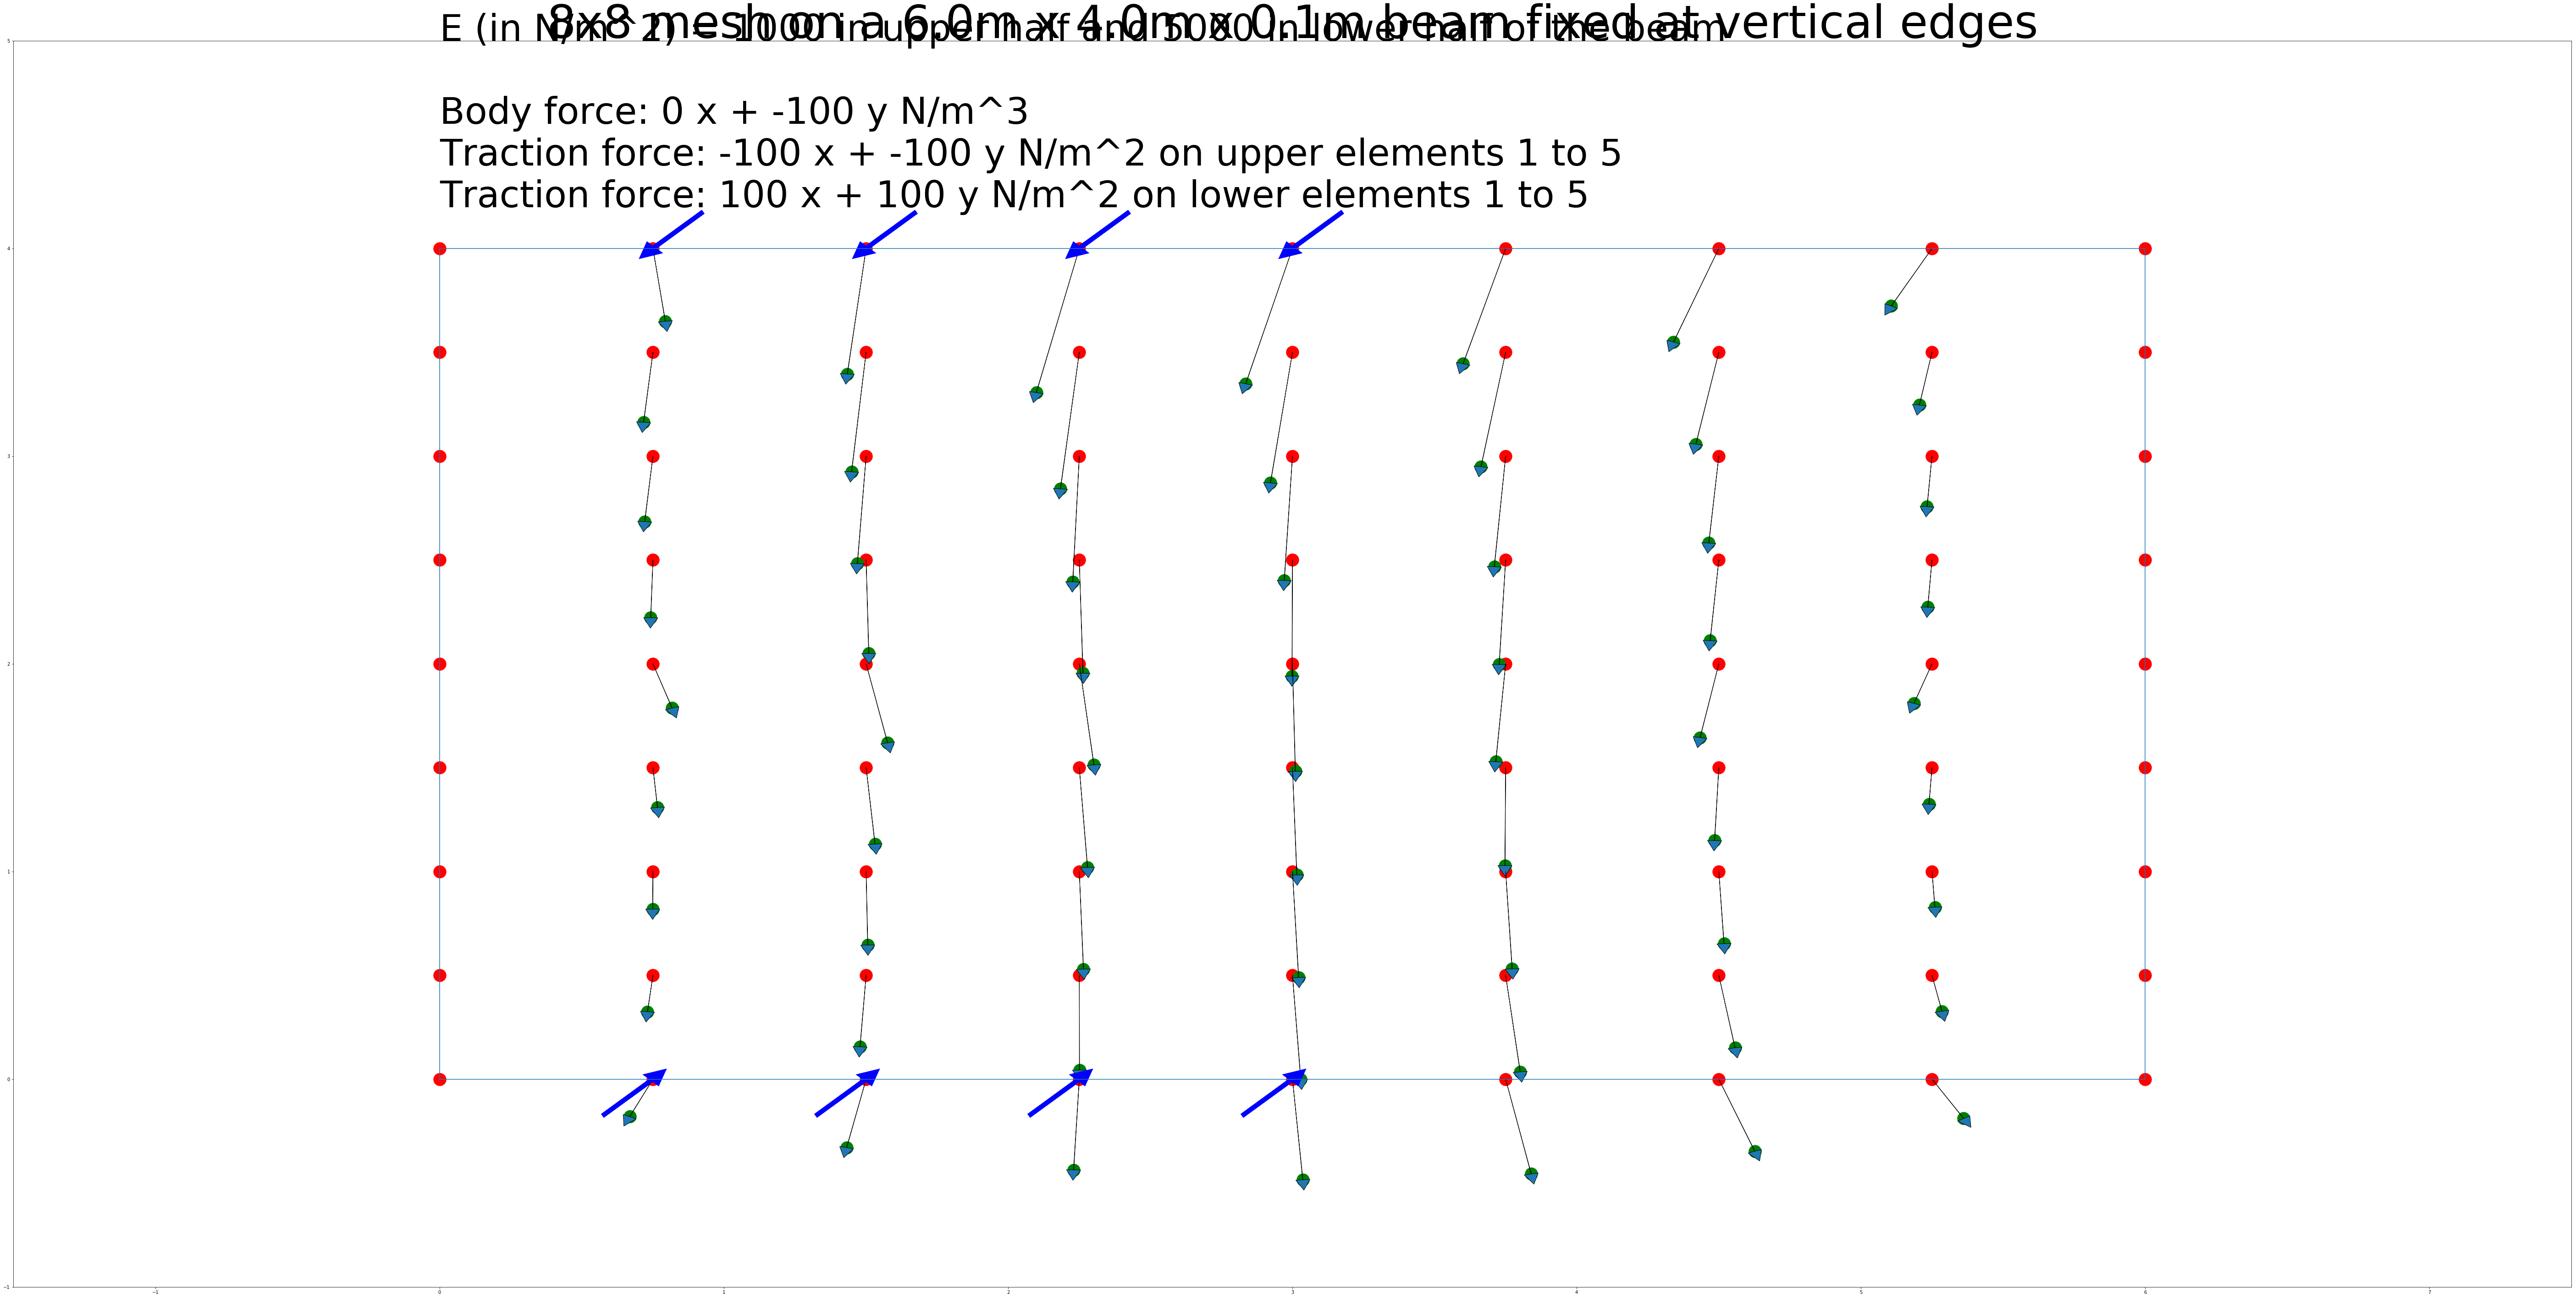

In [128]:
geom, E1, E2, nu1, nu2, divs, dels, frange_upper, frange_lower, f_upper, f_lower, bf, xy = alldata()
def maincall():
    #Uses SOR Method
    geom, E1, E2, nu1, nu2, divs, dels, frange_upper, frange_lower, f_upper, f_lower, bf, xy = alldata()
    elist = elementlist(divs[0], divs[1], divs)
    E = [E1, E2, (E1+E2)/2]
    nu = [nu1, nu2, (nu1+nu2)/2]
    # E and nu are both 3x1 arrays
    nx, ny = divs[0], divs[1]
    print("Computing Kg4d for {}x{} divisions".format(nx, ny))
    Kg4d = K_global(elist, xy, divs, E, nu)
    print("Kg4d computed. Reshaping...")
    Kg = reshape_Kg(Kg4d, divs)
    print("Kg reshaped")
    #bf, frange_upper, f_upper, frange_lower, f_lower = bf, frange_upper, fra, frange, -np.array(f)
    print("Computing Fg...")
    Fg = force_global(bf, frange_upper, f_upper, frange_lower, f_lower, divs, elist).flatten()
    print("Solving d = Kg^-1 Fg...")
    d, num = go(Kg, Fg, 1.6, 'r', 1e-6, 1)
    print("Solution successful.")
    d = d.reshape((nx-1)*(ny+1),2)
    plot_disp(xy, d, geom, E1, E2, nu, divs, dels, bf, frange_upper, f_upper, frange_lower, f_lower)

maincall()